In [44]:
import numpy as np
import scipy as sc
import os
import math
import cv2
import matplotlib.pyplot as plt
import dlib
from numpy.linalg import svd, inv
from scipy.spatial import ConvexHull

np.set_printoptions(suppress=True)
%matplotlib inline
import pandas as pd
np.set_printoptions(suppress=True)
%matplotlib inline
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

In [45]:
# from google.colab import drive
# drive.mount('/content/drive')

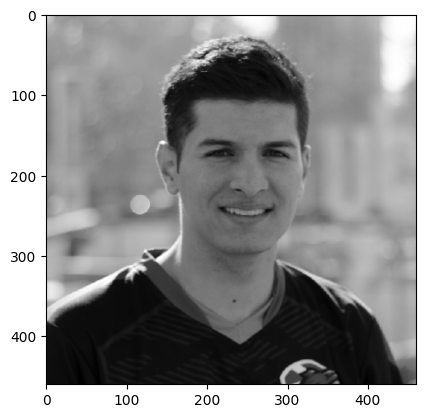

In [56]:
img1_f = 'sources/raoul.png'
img1 = cv2.cvtColor(cv2.cvtColor(cv2.imread(img1_f), cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img1, cmap='gray')

Found 1 Faces!


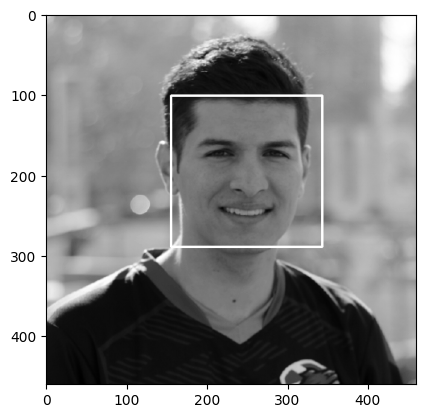

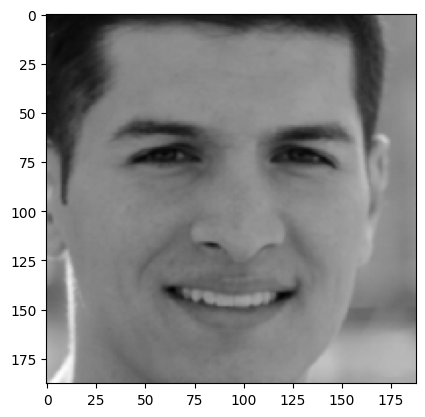

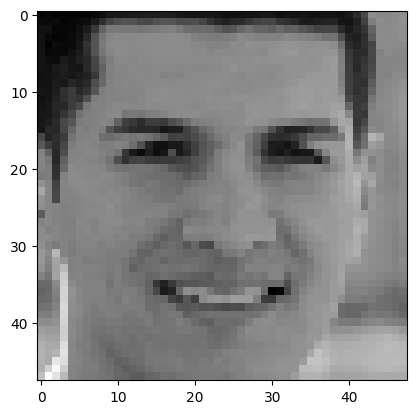

In [57]:
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
# https://github.com/opencv/opencv/tree/3.4/data/haarcascades
# I think we might need to add 2 more classifiers? one for the smile and the other for the eyes
# this way we can use these 3 classifiers to detect emotions? but I don't know for sure yet as we need
# to know how our data will be on the models we are downloading?
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(
        img1,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
)

print("Found {0} Faces!".format(len(faces)))

for (x, y, w, h) in faces:
    cv2.rectangle(img1, (x, y), (x+w, y+h), (255, 0, 0), 2)
    # cv2.ellipse(img1, (x + w//2, y + h//2), (w//2-10, h//2+20), 0, 0, 360, (255, 0, 0), 2)
    roi_img = cv2.cvtColor(cv2.imread(img1_f), cv2.COLOR_BGR2GRAY)[y:y+h, x:x+w]

plt.figure()
plt.imshow(img1, cmap='gray')
plt.figure()
plt.imshow(roi_img, cmap='gray')
roi_img = cv2.resize(roi_img, (48, 48))
plt.figure()
plt.imshow(roi_img, cmap='gray')

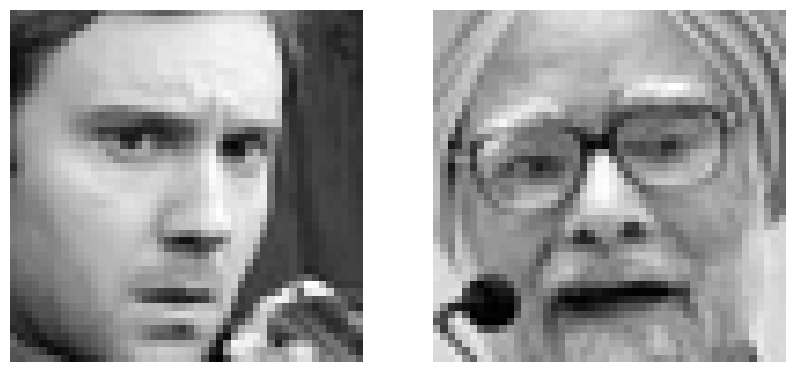

In [2]:
# Load the FER dataset
# File too large, download here https://drive.google.com/file/d/1Sg5bhkS_DAEoxWZyQjRvzjkOap-hKZvV/view
fer_data = pd.read_csv('sources/fer2013.csv')


num_images = 2
image_pixels = fer_data.head(num_images)['pixels'].values

# Reshape the pixel values into images
images = []
for pixels in image_pixels:
    image = np.array(pixels.split(), dtype='uint8')
    image = image.reshape((48, 48))
    images.append(image)

# Display the images
fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

for ax, image in zip(axes, images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()


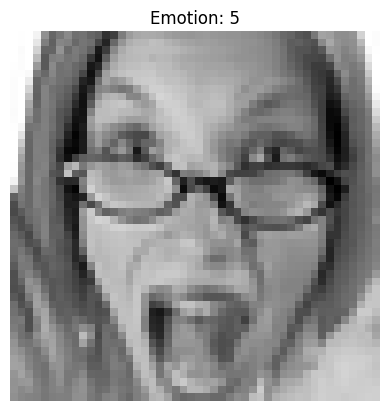

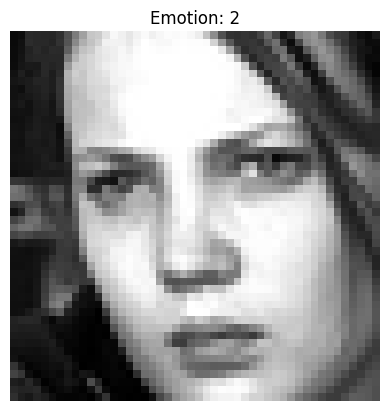

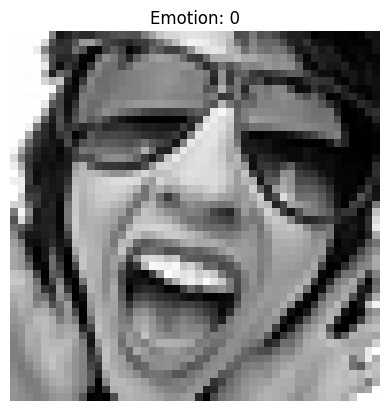

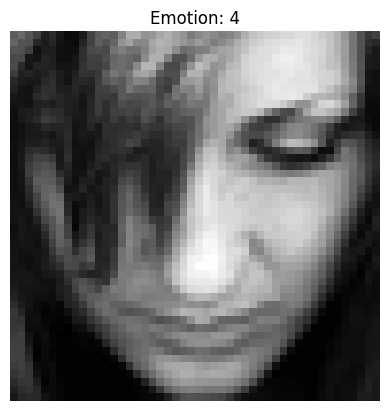

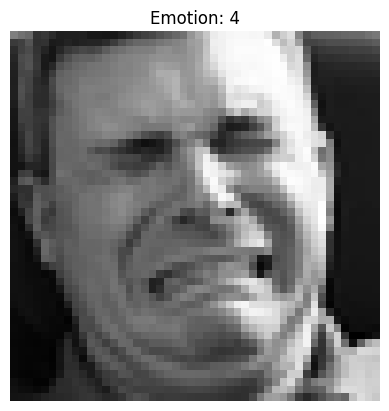

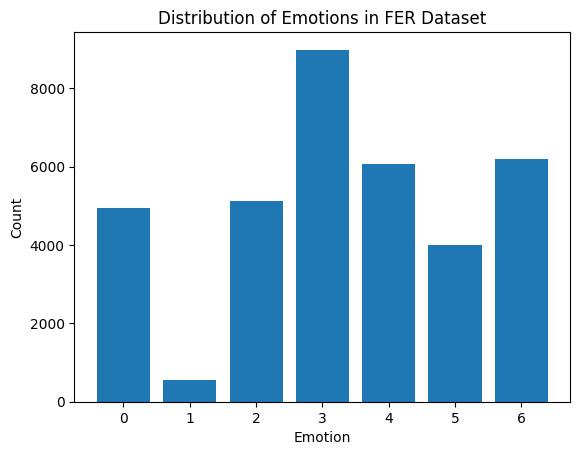

In [3]:
# Display sample images with corresponding labels
sample_indices = np.random.choice(fer_data.index, size=5, replace=False)
for index in sample_indices:
    pixels = fer_data.loc[index, 'pixels']
    emotion = fer_data.loc[index, 'emotion']

    #:0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
    emotion_str = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    
    # Convert pixel string to numpy array
    image = np.fromstring(pixels, dtype=int, sep=' ').reshape((48, 48))

    # Display image with emotion label
    plt.imshow(image, cmap='gray')
    plt.title(f'Emotion: {emotion_str[emotion]}')
    plt.axis('off')
    plt.show()

# Plot emotion distribution
emotion_counts = fer_data['emotion'].value_counts()
plt.bar(emotion_counts.index, emotion_counts.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in FER Dataset')
plt.show()

In [4]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in fer_data.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) #reshape for fitting
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)


In [5]:
X_train = np.array(X_train)
print(X_train.shape)
augment = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
testgen = ImageDataGenerator(rescale=1./255)
augment.fit(X_train)

(28709, 48, 48, 1)


In [6]:
batch_size = 96
train_flow = augment.flow(X_train, y_train, batch_size=batch_size)
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)
#set batch size

In [7]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Input, Dense, Flatten, Dropout, BatchNormalization
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1, l2
import tensorflow as tf

In [40]:
def FER_Model(input_shape=(48,48,1)):
    visible = Input(shape=input_shape, name='input')
    num_classes = 7

    # First Convolutional Block
    conv1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1')(visible)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv2')(conv1)
    conv2 = BatchNormalization()(conv2)
    pool1 = MaxPooling2D(pool_size=(2,2), name='pool1')(conv2)
    drop1 = Dropout(0.3, name='drop1')(pool1)

    # Second Convolutional Block
    conv3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv3')(drop1)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv4')(conv3)
    conv4 = BatchNormalization()(conv4)
    pool2 = MaxPooling2D(pool_size=(2,2), name='pool2')(conv4)
    drop2 = Dropout(0.3, name='drop2')(pool2)

    # Third Convolutional Block
    conv5 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv5')(drop2)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv6')(conv5)
    conv6 = BatchNormalization()(conv6)
    pool3 = MaxPooling2D(pool_size=(2,2), name='pool3')(conv6)
    drop3 = Dropout(0.3, name='drop3')(pool3)

    # Flatten and Output Layer
    flatten = Flatten(name='flatten')(drop3)
    output = Dense(num_classes, activation='softmax', name='output')(flatten)

    # Create Model
    model = Model(inputs=visible, outputs=output)

    return model

In [27]:
def ThreeBlockFER(input_shape=(48,48,1)):
    visible = Input(shape=input_shape, name='input')
    num_classes = 7

    # First Convolutional Block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name='pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name='drop1_1')(pool1_1)

    # Second Convolutional Block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name='pool2_1')(conv2_2)
    drop2_1 = Dropout(0.3, name='drop2_1')(pool2_1)

    # Third Convolutional Block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name='pool3_1')(conv3_2)
    drop3_1 = Dropout(0.3, name='drop3_1')(pool3_1)

    # Flatten and Output Layer
    flatten = Flatten(name='flatten')(drop3_1)
    output = Dense(num_classes, activation='softmax', name='output')(flatten)

    # Create Model
    model = Model(inputs=visible, outputs=output)

    return model


ThreeBlock = ThreeBlockFER()
ThreeBlock.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

## Intermittent Testing Model

In [ ]:
from tensorflow.keras.models import Sequential

In [39]:
def FER_ModelReg(input_shape=(48,48,1)):
    # Regularization parameter
    l2_lambda = 0.001
    #changed from 0.0001
    model = Sequential([
        # 1st block
        Conv2D(64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda), input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 2nd block
        Conv2D(128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 3rd block
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 4th block
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 5th block
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(7, activation='softmax')
    ])
    return model

In [8]:

def FER_Seq(input_shape=(48,48,1)):
    model = Sequential([
        # 1st block
        Conv2D(64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 2nd block
        Conv2D(128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 3rd block
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 4th block
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 5th block
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(7, activation='softmax')
    ])

    return model

In [41]:
model = FER_Model()
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [39]:
model2 = FER_ModelReg()
model2.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
#ended up being the best model

In [9]:
model3 = FER_Seq()
model3.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "FerSeqWeightsBest.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         mode='max',
                                                         save_best_only=True,
                                                         verbose=1)
# model = FER_Model()
# model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [42]:
num_epochs = 80
history = model.fit(train_flow,
                    steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    callbacks= [reduce_lr],
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/80
299/299 [==============================] - 12s 36ms/step - loss: 2.6139 - accuracy: 0.2376 - val_loss: 1.9444 - val_accuracy: 0.1847 - lr: 1.0000e-04
Epoch 2/80
299/299 [==============================] - 11s 35ms/step - loss: 2.1833 - accuracy: 0.2705 - val_loss: 1.7135 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 3/80
299/299 [==============================] - 11s 36ms/step - loss: 2.0337 - accuracy: 0.2911 - val_loss: 1.5974 - val_accuracy: 0.3820 - lr: 1.0000e-04
Epoch 4/80
299/299 [==============================] - 11s 36ms/step - loss: 1.9512 - accuracy: 0.3148 - val_loss: 1.5541 - val_accuracy: 0.4139 - lr: 1.0000e-04
Epoch 5/80
299/299 [==============================] - 11s 36ms/step - loss: 1.8492 - accuracy: 0.3478 - val_loss: 1.7620 - val_accuracy: 0.3840 - lr: 1.0000e-04
Epoch 6/80
299/299 [==============================] - 11s 36ms/step - loss: 1.7973 - accuracy: 0.3634 - val_loss: 1.7334 - val_accuracy: 0.3902 - lr: 1.0000e-04
Epoch 7/80
299/299 [==============

In [31]:
num_epochs = 100
#reg model
#attempted with Lr = 0.0001, kernel reg at 0.0001
history2 = model2.fit(train_flow,
                    steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    callbacks= [reduce_lr],
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/100
299/299 [==============================] - 25s 76ms/step - loss: 2.8694 - accuracy: 0.2111 - val_loss: 2.3075 - val_accuracy: 0.2477 - lr: 1.0000e-04
Epoch 2/100
299/299 [==============================] - 22s 73ms/step - loss: 2.3371 - accuracy: 0.2387 - val_loss: 2.3786 - val_accuracy: 0.2489 - lr: 1.0000e-04
Epoch 3/100
299/299 [==============================] - 22s 74ms/step - loss: 2.2381 - accuracy: 0.2557 - val_loss: 2.2400 - val_accuracy: 0.2677 - lr: 1.0000e-04
Epoch 4/100
299/299 [==============================] - 22s 74ms/step - loss: 2.2065 - accuracy: 0.2684 - val_loss: 2.3066 - val_accuracy: 0.2756 - lr: 1.0000e-04
Epoch 5/100
299/299 [==============================] - 23s 76ms/step - loss: 2.1666 - accuracy: 0.2876 - val_loss: 2.2008 - val_accuracy: 0.3024 - lr: 1.0000e-04
Epoch 6/100
299/299 [==============================] - 23s 77ms/step - loss: 2.1320 - accuracy: 0.3145 - val_loss: 2.2799 - val_accuracy: 0.3015 - lr: 1.0000e-04
Epoch 7/100
299/299 [=======

In [40]:
num_epochs = 80
#reg model
#attempted with Lr = 0.0001, kernel reg at 0.001
history2 = model2.fit(train_flow,
                    steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    callbacks= [reduce_lr],
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/80
299/299 [==============================] - 25s 79ms/step - loss: 6.7382 - accuracy: 0.2044 - val_loss: 6.1253 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/80
299/299 [==============================] - 23s 78ms/step - loss: 6.1249 - accuracy: 0.2429 - val_loss: 6.0706 - val_accuracy: 0.2492 - lr: 1.0000e-04
Epoch 3/80
299/299 [==============================] - 24s 79ms/step - loss: 5.9955 - accuracy: 0.2560 - val_loss: 5.9373 - val_accuracy: 0.2587 - lr: 1.0000e-04
Epoch 4/80
299/299 [==============================] - 24s 80ms/step - loss: 5.9052 - accuracy: 0.2685 - val_loss: 5.8846 - val_accuracy: 0.2711 - lr: 1.0000e-04
Epoch 5/80
299/299 [==============================] - 24s 80ms/step - loss: 5.8161 - accuracy: 0.2824 - val_loss: 5.7900 - val_accuracy: 0.2934 - lr: 1.0000e-04
Epoch 6/80
299/299 [==============================] - 24s 80ms/step - loss: 5.7150 - accuracy: 0.3022 - val_loss: 5.6514 - val_accuracy: 0.3274 - lr: 1.0000e-04
Epoch 7/80
299/299 [==============

In [28]:

num_epochs = 80
#sequential model. Essentially the same
historyThreeBlock = ThreeBlock.fit(train_flow,
                 steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    callbacks= [reduce_lr],
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/80
299/299 [==============================] - 12s 36ms/step - loss: 9.5071 - accuracy: 0.2384 - val_loss: 8.6518 - val_accuracy: 0.1363 - lr: 1.0000e-04
Epoch 2/80
299/299 [==============================] - 10s 34ms/step - loss: 8.6207 - accuracy: 0.2693 - val_loss: 7.9201 - val_accuracy: 0.2863 - lr: 1.0000e-04
Epoch 3/80
299/299 [==============================] - 10s 35ms/step - loss: 7.9439 - accuracy: 0.3001 - val_loss: 7.2289 - val_accuracy: 0.3953 - lr: 1.0000e-04
Epoch 4/80
299/299 [==============================] - 10s 35ms/step - loss: 7.2920 - accuracy: 0.3277 - val_loss: 6.6325 - val_accuracy: 0.4105 - lr: 1.0000e-04
Epoch 5/80
299/299 [==============================] - 10s 35ms/step - loss: 6.6497 - accuracy: 0.3560 - val_loss: 5.9405 - val_accuracy: 0.4572 - lr: 1.0000e-04
Epoch 6/80
299/299 [==============================] - 11s 35ms/step - loss: 6.0040 - accuracy: 0.3801 - val_loss: 5.3335 - val_accuracy: 0.4823 - lr: 1.0000e-04
Epoch 7/80
299/299 [==============

In [14]:

num_epochs = 80
#sequential model. Essentially the same
history3 = model3.fit(train_flow,
                    steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    callbacks= [reduce_lr,checkpoint_callback],
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/80
299/299 [==============================] - ETA: 0s - loss: 6.6840 - accuracy: 0.2097
Epoch 1: val_accuracy improved from -inf to 0.25141, saving model to FerSeqWeightsBest.h5
299/299 [==============================] - 28s 76ms/step - loss: 6.6840 - accuracy: 0.2097 - val_loss: 6.0966 - val_accuracy: 0.2514 - lr: 1.0000e-04
Epoch 2/80
299/299 [==============================] - ETA: 0s - loss: 6.1310 - accuracy: 0.2370
Epoch 2: val_accuracy did not improve from 0.25141
299/299 [==============================] - 22s 72ms/step - loss: 6.1310 - accuracy: 0.2370 - val_loss: 6.0691 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 3/80
299/299 [==============================] - ETA: 0s - loss: 5.9949 - accuracy: 0.2551
Epoch 3: val_accuracy improved from 0.25141 to 0.26267, saving model to FerSeqWeightsBest.h5
299/299 [==============================] - 22s 74ms/step - loss: 5.9949 - accuracy: 0.2551 - val_loss: 5.9576 - val_accuracy: 0.2627 - lr: 1.0000e-04
Epoch 4/80
299/299 [========

In [15]:
model_json = model3.to_json()
with open("seq.json", "w") as json_file:
    json_file.write(model_json)
model3.save_weights("seq.h5")

print("model saved")

model saved


In [38]:
model_json = model.to_json()
with open("original.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("original.h5")

print("model saved")

model saved


In [29]:
model_json = ThreeBlock.to_json()
with open("ThreeBlock.json", "w") as json_file:
    json_file.write(model_json)
ThreeBlock.save_weights("ThreeBlock.h5")

print("model saved")

model saved


In [43]:
#save in newer keras format
model2.save("seq.keras")

In [35]:
print(tf.__version__)
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
TensorFlow version: 2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Reload Compiled Model and Test if working

In [19]:
# new_model = tf.keras.models.load_model('model.keras')
#Only works if you are in same kernel of trained model, if not. Need to recompile.
model.load_weights('sources/model.h5')

In [22]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(model.predict(X_test).shape)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.6381 - loss: 2.4114
Restored model, accuracy: 63.75%
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step
(3589, 7)


## Test Runs of Models

## Original

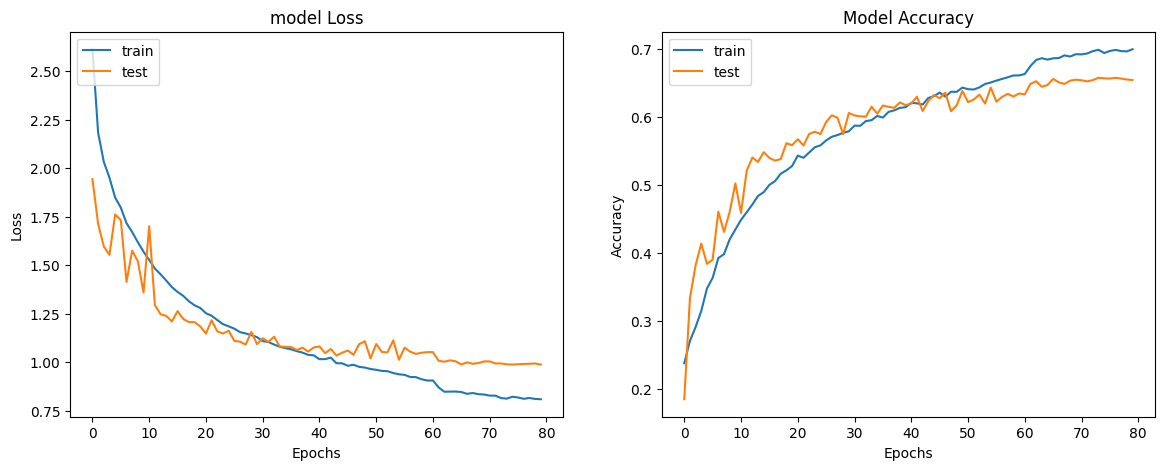

In [43]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
train_loss, train_accu = model.evaluate(train_flow)
test_loss, test_accu = model.evaluate(test_flow)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 0s 11ms/step - loss: 0.9913 - accuracy: 0.6534
final train accuracy = 74.05 , validation accuracy = 65.34


## Intermittent Testing

In [34]:
#with reg on 100 epo. need to reduce loss
train_loss, train_accu = model2.evaluate(train_flow)
test_loss, test_accu = model2.evaluate(test_flow)
# pred_results = model.evaluate(test_flow)
print(pred_results)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 1s 24ms/step - loss: 1.2613 - accuracy: 0.6704
[0.9996629357337952, 0.6823627948760986]
final train accuracy = 80.50 , validation accuracy = 67.04


In [41]:
#with reg on 100 epo. need to reduce loss
train_loss, train_accu = model2.evaluate(train_flow)
test_loss, test_accu = model2.evaluate(test_flow)
# pred_results = model.evaluate(test_flow)
print(pred_results)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 1s 23ms/step - loss: 1.5386 - accuracy: 0.6840
[0.9996629357337952, 0.6823627948760986]
final train accuracy = 86.75 , validation accuracy = 68.40


In [12]:
ogmodel = FER_ModelReg()
ogmodel.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
ogmodel.load_weights('86ta68va.h5')
ogmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

In [29]:
#This is the final result of testing for (FER_ModelReg).
#Will clean up and use findings towards FERSeq
train_loss, train_accu = ogmodel.evaluate(train_flow)
test_loss, test_accu = ogmodel.evaluate(test_flow)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 1s 24ms/step - loss: 1.5386 - accuracy: 0.6840
final train accuracy = 86.96 , validation accuracy = 68.40


In [33]:
#Testing predict output
total_samples = len(test_flow)
print(total_samples)
steps_per_epoch = total_samples // batch_size
if total_samples % batch_size != 0:
    steps_per_epoch += 1  # Include the remaining samples in the last incomplete batch

test_accu = ogmodel.predict(test_flow, steps = 38)
predicted_labels = np.argmax(test_accu, axis=1)

print(predicted_labels)

38
38/38 [==============================] - 1s 22ms/step
[5 1 3 ... 4 4 6]


## Intermittent

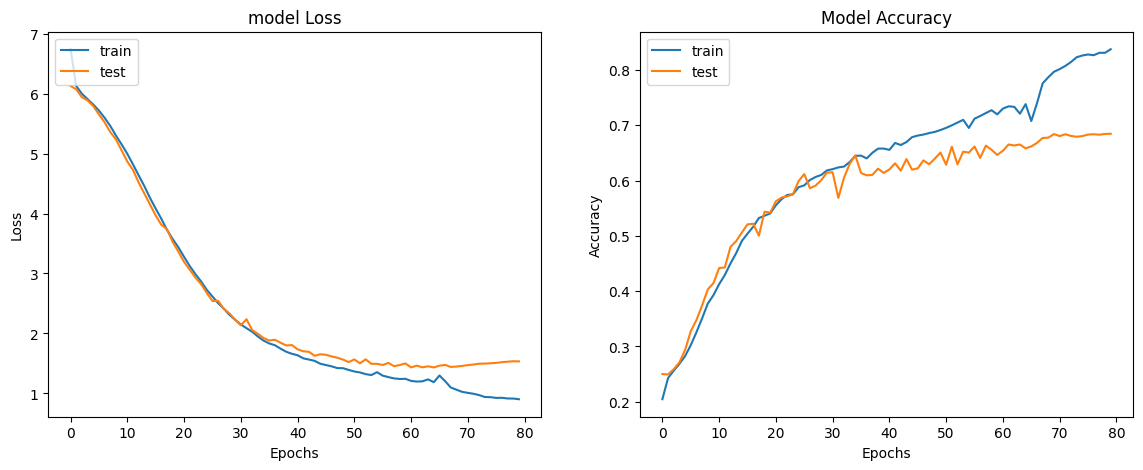

In [44]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

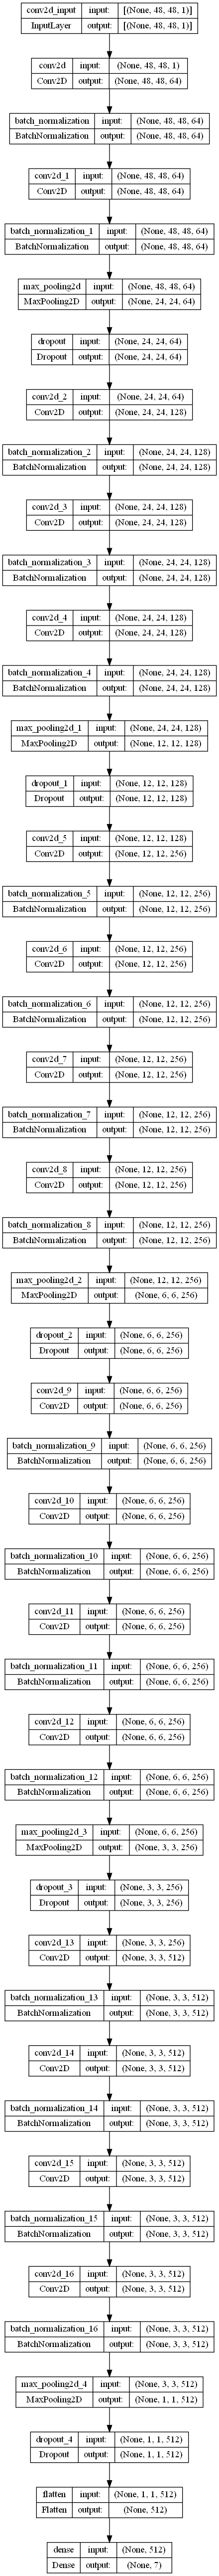

In [26]:
tf.keras.utils.plot_model(model, to_file='fernet.png', show_shapes=True, show_layer_names=True)
#pip install pydot and conda install graphviz

## Final

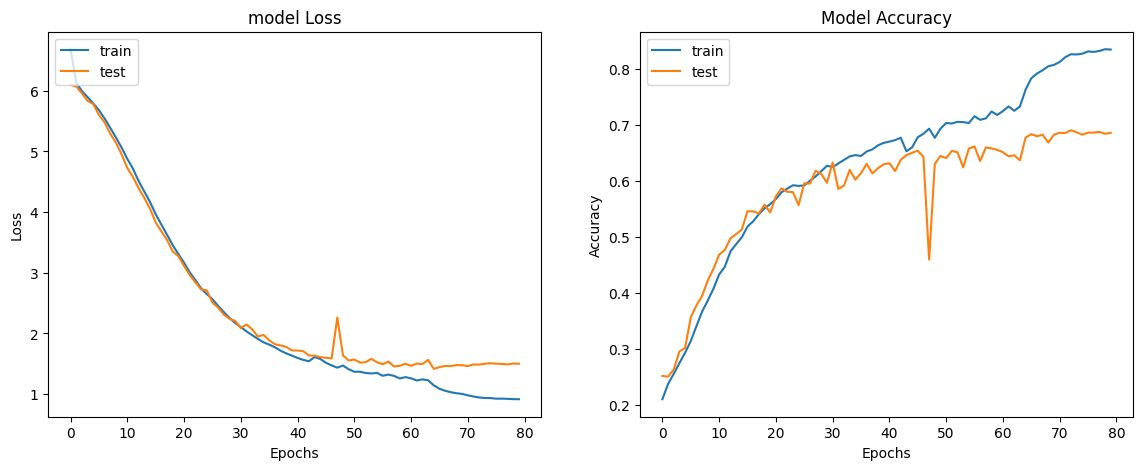

In [16]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
from tensorflow.keras.models import model_from_json
model = model_from_json(open("seq.json", "r").read())
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.load_weights("FerSeqWeightsBest.h5")

In [25]:
#This is the current best model (FerSeq)
train_loss, train_accu = model.evaluate(train_flow)
test_loss, test_accu = model.evaluate(test_flow)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 1s 22ms/step - loss: 1.4879 - accuracy: 0.6902
final train accuracy = 86.08 , validation accuracy = 69.02


# Three Block

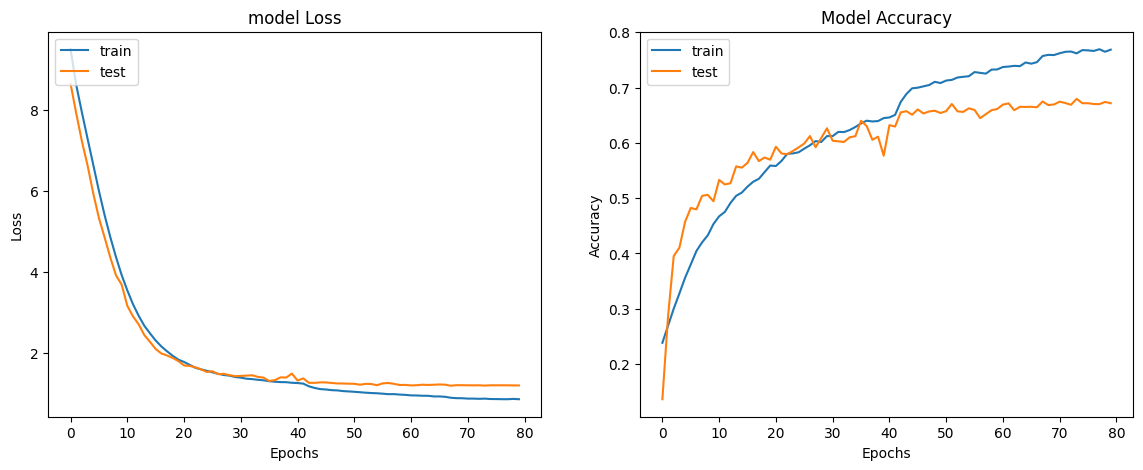

In [30]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(historyThreeBlock.history['accuracy'])
plt.plot(historyThreeBlock.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(historyThreeBlock.history['loss'])
plt.plot(historyThreeBlock.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
#This is the current best model (FerSeq)
train_loss, train_accu = ThreeBlock.evaluate(train_flow)
test_loss, test_accu = ThreeBlock.evaluate(test_flow)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 0s 11ms/step - loss: 1.2005 - accuracy: 0.6715
final train accuracy = 81.42 , validation accuracy = 67.15


## Testing pretrained VGG-16 For comparison

In [54]:
from tensorflow.keras.applications import VGG16
#Pretrained on rgb images only
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(7, activation='softmax')(x)  # Assuming num_classes is the number of output classes

VGGModel = Model(inputs=base_model.input, outputs=output)

VGGModel.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])


In [63]:
# Create image data generators for RGB
train_datagenRGB = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
)
test_datagenRGB = ImageDataGenerator(
    rescale=1./255,
)

# Set batch size
batch_size = 96
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)
# Create flow generators
train_flowRGB = train_datagenRGB.flow(X_train_rgb, y_train, batch_size=batch_size)
test_flowRGB = test_datagenRGB.flow(X_test_rgb, y_test, batch_size=batch_size)

In [64]:
num_epochs = 80
VGGhistory = VGGModel.fit(train_flowRGB,
                    steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flowRGB,
                    callbacks= [reduce_lr],
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/80
299/299 [==============================] - 18s 57ms/step - loss: 1.6597 - accuracy: 0.3411 - val_loss: 1.5853 - val_accuracy: 0.3916 - lr: 0.0010
Epoch 2/80
299/299 [==============================] - 17s 57ms/step - loss: 1.5970 - accuracy: 0.3753 - val_loss: 1.5827 - val_accuracy: 0.3773 - lr: 0.0010
Epoch 3/80
299/299 [==============================] - 17s 56ms/step - loss: 1.5686 - accuracy: 0.3894 - val_loss: 1.5457 - val_accuracy: 0.3995 - lr: 0.0010
Epoch 4/80
299/299 [==============================] - 18s 59ms/step - loss: 1.5505 - accuracy: 0.3964 - val_loss: 1.5398 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 5/80
299/299 [==============================] - 19s 62ms/step - loss: 1.5381 - accuracy: 0.4026 - val_loss: 1.5426 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 6/80
299/299 [==============================] - 18s 59ms/step - loss: 1.5230 - accuracy: 0.4108 - val_loss: 1.5416 - val_accuracy: 0.4079 - lr: 0.0010
Epoch 7/80
299/299 [==============================] - 19s 

In [65]:
model_json = VGGModel.to_json()
with open("VGGModel.json", "w") as json_file:
    json_file.write(model_json)
VGGModel.save_weights("VGGModel.h5")

print("model saved")

model saved


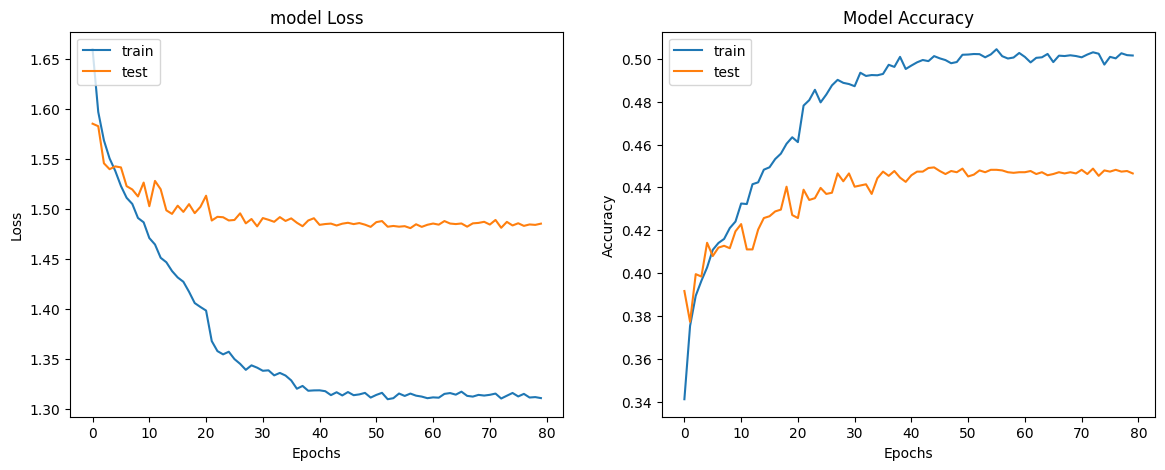

In [66]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(VGGhistory.history['accuracy'])
plt.plot(VGGhistory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(VGGhistory.history['loss'])
plt.plot(VGGhistory.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
#This is the current best model (FerSeq)
train_loss, train_accu = VGGModel.evaluate(train_flowRGB)
test_loss, test_accu = VGGModel.evaluate(test_flowRGB)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 1s 37ms/step - loss: 1.4850 - accuracy: 0.4472
final train accuracy = 50.27 , validation accuracy = 44.72
